In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, pickle
import numpy as np

# Almost everything from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, log_loss
"""
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier
"""
from sklearn.naive_bayes import MultinomialNB

# NLTK package
!pip install --disable-pip-version-check -q nltk
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

This part is by Russell.

The following cell is optional because we don't want to see red warnings here and there.

In [2]:
# Optional
toggle_warn = False

def warn(*args, **kwargs):
    pass
import warnings

if not toggle_warn:
    warnings.warn = warn
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

Import data from GitHub to make things easier.

In [3]:
train_data = pd.read_csv("https://raw.githubusercontent.com/RussellDash332/CS3244-Twemoji/main/Datasets/train_text_emoji_clean.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/RussellDash332/CS3244-Twemoji/main/Datasets/test_text_emoji_clean.csv")
valid_data = pd.read_csv("https://raw.githubusercontent.com/RussellDash332/CS3244-Twemoji/main/Datasets/valid_text_emoji_clean.csv")

## Sanity Check

In [4]:
train_data.shape

(52884, 3)

In [5]:
train_data

,annotations,tweets,labels
0,😂,school is so dead o my god,0
1,😂,lol ive been told mine is worse than yours but...,0
2,😂,im excited to hear them that shit is going rat...,0
3,😂,damn alicia knows everything even indirect tweets,0
4,😂,that sound like everything,0
...,...,...,...
52879,🙃,or that picture was just cute to you,11
52880,🙃,im tow wit some gas still hate me,11
52881,🙃,yeah you kinda do,11
52882,🙃,nothing wit youuuu raymundo,11


Eventually this function may not be needed, but it's good to have in case of multi-label classification!

In [6]:
def binarize(label):
    return [0]*(label) + [1] + [0]*(11-label)

A function that outputs the things we need for evaluation in one go.

In [7]:
def evaluate(sub, y_val, predicted, use_heatmap=True):
    print(f'{sub} Accuracy:', accuracy_score(y_val, predicted))
    print(f'{sub} F1 Score:', f1_score(y_val, predicted, average='weighted'))
    if use_heatmap:
        print('Confusion Matrix:')
        ax = sns.heatmap(confusion_matrix(predicted, y_val), annot=True, fmt="d")
        ax.set_ylabel("Predicted")
        ax.set_xlabel("Actual")

Prepare a function to lemmatize and filter stopwords to even process the words better.

In [8]:
# https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

def filter_stopword(tokenized_text):
    stop_words = set(stopwords.words("english"))
    return list(filter(lambda x: x not in stop_words, tokenized_text))

def lemmatize_better(sentence):
    return " ".join(list(map(WordNetLemmatizer().lemmatize, filter_stopword(word_tokenize(sentence)))))

In [9]:
lemmatize_better("the quick brown foxes were jumping over the laziest dogs ever")

'quick brown fox jumping laziest dog ever'

Create another dataset where we apply this modified lemmatization.

In [10]:
train_data_nltk = train_data.copy()
train_data_nltk.tweets = train_data.tweets.apply(lemmatize_better)
valid_data_nltk = valid_data.copy()
valid_data_nltk.tweets = valid_data.tweets.apply(lemmatize_better)
test_data_nltk = test_data.copy()
test_data_nltk.tweets = test_data.tweets.apply(lemmatize_better)

In [11]:
train_data_nltk = train_data_nltk[train_data_nltk.tweets != ""]
valid_data_nltk = valid_data_nltk[valid_data_nltk.tweets != ""]
test_data_nltk = test_data_nltk[test_data_nltk.tweets != ""]

In [12]:
train_data_nltk

,annotations,tweets,labels
0,😂,school dead god,0
1,😂,lol ive told mine worse dont believe,0
2,😂,im excited hear shit going rattle soul,0
3,😂,damn alicia know everything even indirect tweet,0
4,😂,sound like everything,0
...,...,...,...
52879,🙃,picture cute,11
52880,🙃,im tow wit gas still hate,11
52881,🙃,yeah kinda,11
52882,🙃,nothing wit youuuu raymundo,11


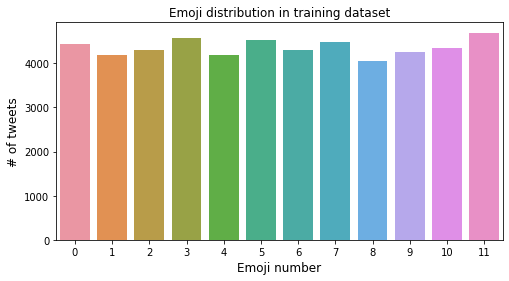

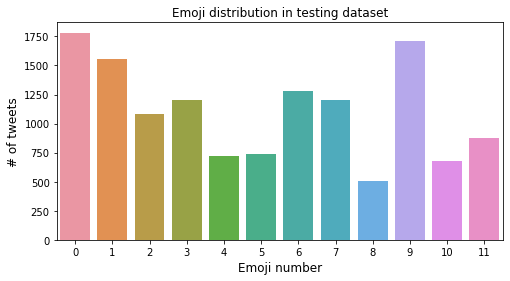

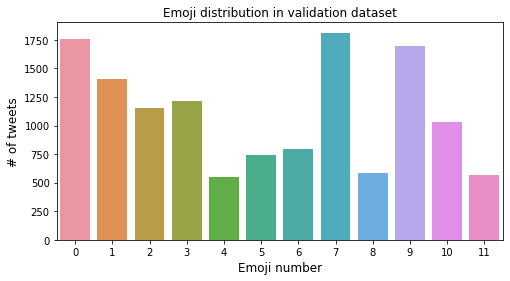

In [13]:
# https://fallfordata.com/multi-label-classification-of-texts-with-nltk/
for data, name in [(train_data_nltk, "training"), (test_data_nltk, "testing"), (valid_data_nltk, "validation")]:
    x = data.labels.value_counts()
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x=x.index, y=x.values)
    plt.title(f"Emoji distribution in {name} dataset")
    plt.xlabel('Emoji number', fontsize=12)
    plt.ylabel('# of tweets', fontsize=12)
    plt.show()

## The Model

Start by creating a TFIDF Vectorizer which uses a RegexpTokenizer. By default the norm is L2, but it's good to include.
After that transform all train, valid, and test data using this, but fit only the training data.

Once we're good with the transformation, simply use the transformed data for the X features and then fit them to a MultinomialNB model.

In [14]:
tf = TfidfVectorizer(ngram_range=(1, 5), tokenizer=token.tokenize, norm="l2")
train_text_tf = tf.fit_transform(train_data_nltk.tweets)
valid_text_tf = tf.transform(valid_data_nltk.tweets) # do not fit, just transform
test_text_tf = tf.transform(test_data_nltk.tweets) # do not fit, just transform

X_train, X_test, y_train, y_test = train_text_tf, valid_text_tf, train_data_nltk.labels, valid_data_nltk.labels
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)

As seen below, this is an example of the vector obtained when we predict the word "Hello". Index 5 has the highest probability, so it goes to class 5.

In [15]:
clf.predict_proba(tf.transform(["Hello"]))

array([[0.05322537, 0.0426711 , 0.15423027, 0.03073576, 0.14849723,
        0.31339174, 0.02165031, 0.03089866, 0.07021057, 0.04700061,
        0.02948067, 0.05800773]])

In [16]:
clf.predict(tf.transform(["Hello"]))

array([5], dtype=int64)

Training Loss = 2.2047096704447946
Training Accuracy: 0.25270351456893964
Training F1 Score: 0.25328635837762536
Confusion Matrix:


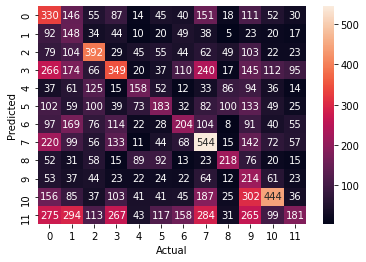

In [17]:
print("Training Loss =", -np.mean(np.sum(np.array(list(map(binarize, y_test))) * clf.predict_log_proba(X_test), axis=1)))
evaluate("Training", y_test, predicted)

Test Loss = 2.2185783858982817
Test Accuracy: 0.24313784310784461
Test F1 Score: 0.23847250083291313
Confusion Matrix:


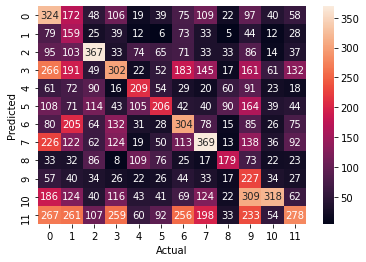

In [18]:
print("Test Loss =", -np.mean(np.sum(np.array(list(map(binarize, test_data_nltk.labels))) * clf.predict_log_proba(test_text_tf), axis=1)))
evaluate("Test", test_data_nltk.labels, clf.predict(test_text_tf))

## Micro Averaging

In this case, we're going to evaluate just on the test dataset. This is done as a way to improve evaluation metrics especially on imbalanced datasets.

In [19]:
test_actual = test_data_nltk.labels
test_predict = clf.predict(test_text_tf)

In [20]:
TP, FP, TN, FN = 0, 0, 0, 0
num_emojis = 12

for i in range(num_emojis):
    test_actual_i = list(map(lambda x: int(x == i), test_actual))
    test_predict_i = list(map(lambda x: 2*int(x == i), test_predict))
    # TP: 3, TN: 0, FP: 2, FN: 1
    test_check_i = [test_actual_i[k] + test_predict_i[k] for k in range(len(test_actual_i))]
    TP += test_check_i.count(3) / num_emojis
    TN += test_check_i.count(0) / num_emojis
    FP += test_check_i.count(2) / num_emojis
    FN += test_check_i.count(1) / num_emojis

print("True Positive:", round(TP))
print("True Negative:", round(TN))
print("False Positive:", round(FP))
print("False Negative:", round(FN))
print()
print("Precision:", TP / (TP + FP))
print("Recall:", TP / (TP + FN))
print("F1 score:", TP / (TP + (FP + FN) / 2))

True Positive: 270
True Negative: 11382
False Positive: 841
False Negative: 841

Precision: 0.24313784310784467
Recall: 0.24313784310784467
F1 score: 0.24313784310784467


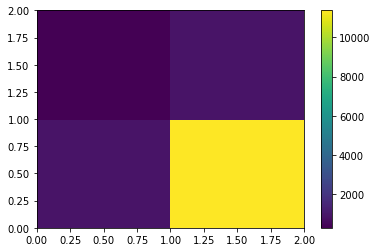

In [21]:
cleaned_confusion_matrix = [[FN, TN], [TP, FP]]
heatmap = plt.pcolor(cleaned_confusion_matrix)
plt.colorbar(heatmap)
plt.show()

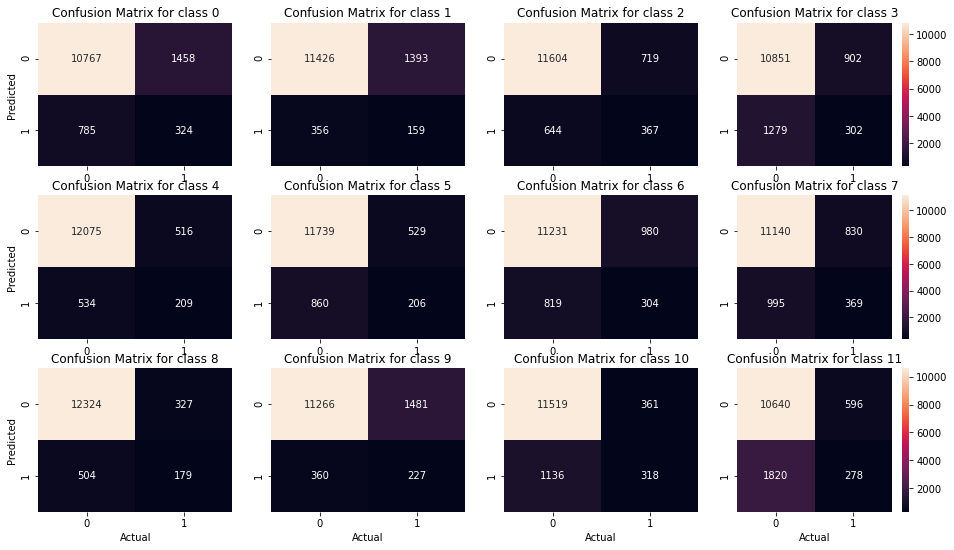

In [22]:
fig, axes = plt.subplots(3, 4, figsize=(16,9))
precisions, recalls, f1_scores = [], [], []
for i in range(num_emojis):
    test_actual_i = list(map(lambda x: int(x == i), test_actual))
    test_predict_i = list(map(lambda x: 2*int(x == i), test_predict))
    # TP: 3, TN: 0, FP: 2, FN: 1
    test_check_i = [test_actual_i[k] + test_predict_i[k] for k in range(len(test_actual_i))]
    TP_i = test_check_i.count(3)
    TN_i = test_check_i.count(0)
    FP_i = test_check_i.count(2)
    FN_i = test_check_i.count(1)
    ax = sns.heatmap(ax=axes[i//4, i % 4], data=[[TN_i, FN_i], [FP_i, TP_i]], annot=True, fmt="d", cbar=(i % 4 == 3))
    ax.set_title(f"Confusion Matrix for class {i}")
    precisions.append(TP_i / (TP_i + FP_i))
    recalls.append(TP_i / (TP_i + FN_i))
    f1_scores.append(TP_i / (TP_i + (FP_i + FN_i) / 2))
    if i % 4 == 0:
        ax.set_ylabel("Predicted")
    if i // 4 == 2:
        ax.set_xlabel("Actual")
plt.show()

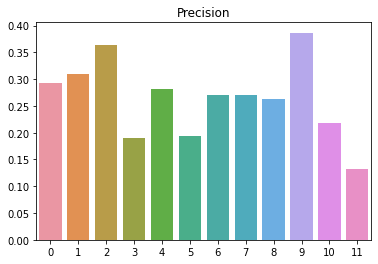

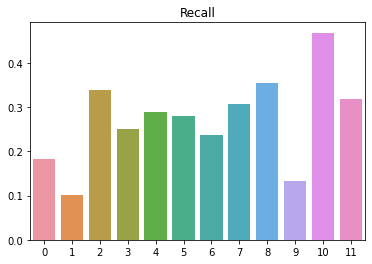

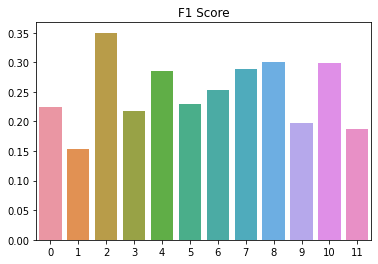

In [23]:
sns.barplot(x=list(range(12)), y=precisions).set_title("Precision")
plt.show()
sns.barplot(x=list(range(12)), y=recalls).set_title("Recall")
plt.show()
sns.barplot(x=list(range(12)), y=f1_scores).set_title("F1 Score")
plt.show()

## Saving the Model

In [24]:
pickle.dump(tf, open(os.getcwd() + "\\tfidf.pkl", 'wb'))
pickle.dump(clf, open(os.getcwd() + "\\nltk-sklearn.pkl", 'wb'))

## Predict an emoji! (badly)

In [29]:
emoji_map = pd.read_csv(os.getcwd() + "\..\Datasets\Original\emoji_map_1791.csv")
emoji_idx = [1381, 1424, 1392, 1447, 186, 1389, 1420, 1620, 1403, 763, 1138, 1446]
emoji_list = list(map(lambda x: emoji_map.iloc[x, 0], emoji_idx))

def give_me_emoji(sentence):
    sen = lemmatize_better(sentence)
    tfidf = pickle.load(open(os.getcwd() + "\\tfidf.pkl", 'rb'))
    nb_model = pickle.load(open(os.getcwd() + "\\nltk-sklearn.pkl", 'rb'))
    return emoji_list[nb_model.predict(tfidf.transform([sen]))[0]]

emoji_list

['😂', '😭', '😍', '🙄', '❤', '😊', '😩', '🤔', '😘', '🏽', '💯', '🙃']

In [31]:
test = [1, 1808, 3375, 4467, 5683, 6413, 7156, 8465, 9684, 10192, 11916, 12605]
smp = test_data.loc[test,:]
smp["pred"] = smp["tweets"].apply(give_me_emoji)
smp

,annotations,tweets,labels,pred
1,😂,lord were coo as lol just waiting for break so...,0,😩
1808,😭,fountain beverage im really fucking crying,1,😭
3375,😍,love me some bandana,2,❤
4467,🙄,can i just win the lottery or something be i h...,3,😭
5683,❤,me and all the fellow hoes love you thank you ...,4,❤
6413,😊,your welcome,5,😊
7156,😩,need ok,6,🙄
8465,🤔,why do women get so emotional over food better...,7,🙃
9684,😘,goodluck big you can do it goodluck too for fi...,8,😘
10192,🏽,amen,9,🏽


## Attempt Using Tensorflow (unused)
Not sure why is this giving me a much lower accuracy but I guess sklearn is viable enough!

In [17]:
# Bringing in Tensorflow to go deeper?
np.random.seed(3244)
import tensorflow as tf
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import Normalizer

In [ ]:
%%time

tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), tokenizer=token.tokenize, norm="l2")
train_text_tf = tfidf.fit_transform(train_data_nltk.tweets)
valid_text_tf = tfidf.transform(valid_data_nltk.tweets) # do not fit, just transform
test_text_tf = tfidf.transform(test_data_nltk.tweets) # do not fit, just transform

X_train, X_val, y_train, y_val = train_text_tf, valid_text_tf, train_data_nltk.labels, valid_data_nltk.labels

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=50000))
model.add(Dropout(0.2))
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
(X_train, y_train)

In [22]:
# https://github.com/tthustla/twitter_sentiment_analysis_part9/blob/master/Capstone_part4-Copy7.ipynb
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch / batch_size
    counter = 0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_st = tf.sparse.slice(X_data, [batch_size*counter, 0], [batch_size, X_data.shape[1]])
        X_batch = tf.sparse.to_dense(tf.sparse.reorder(X_st)).numpy()
        y_batch = y_data[index_batch]
        counter += 1
        yield X_batch, y_batch
        if (counter > number_of_batches):
            counter = 0

In [23]:
# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [24]:
X_train_reordered = tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(X_train))
X_val_reordered = tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(X_val))

In [ ]:
X_train_reordered.shape

In [ ]:
batch_size = 32

hist = model.fit_generator(
    generator=batch_generator(X_train_reordered, np.array(y_train), batch_size),
    epochs=10, validation_data=(X_val_reordered, np.array(y_val)),
    steps_per_epoch=X_train_reordered.shape[0] / batch_size)
model.save(os.getcwd() + "\\nltk-keras.h5")

In [ ]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label = "Training loss")
    plt.plot(epochs, val_loss, label = "Validation loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label = "Training accuracy")
    plt.plot(epochs, val_accuracy, label = "Validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [ ]:
plot_loss_curves(hist) # weird...